# AIN313 Assignment 2


### By Adam Sattout, b2220765061

# Part 1: Throery Questions

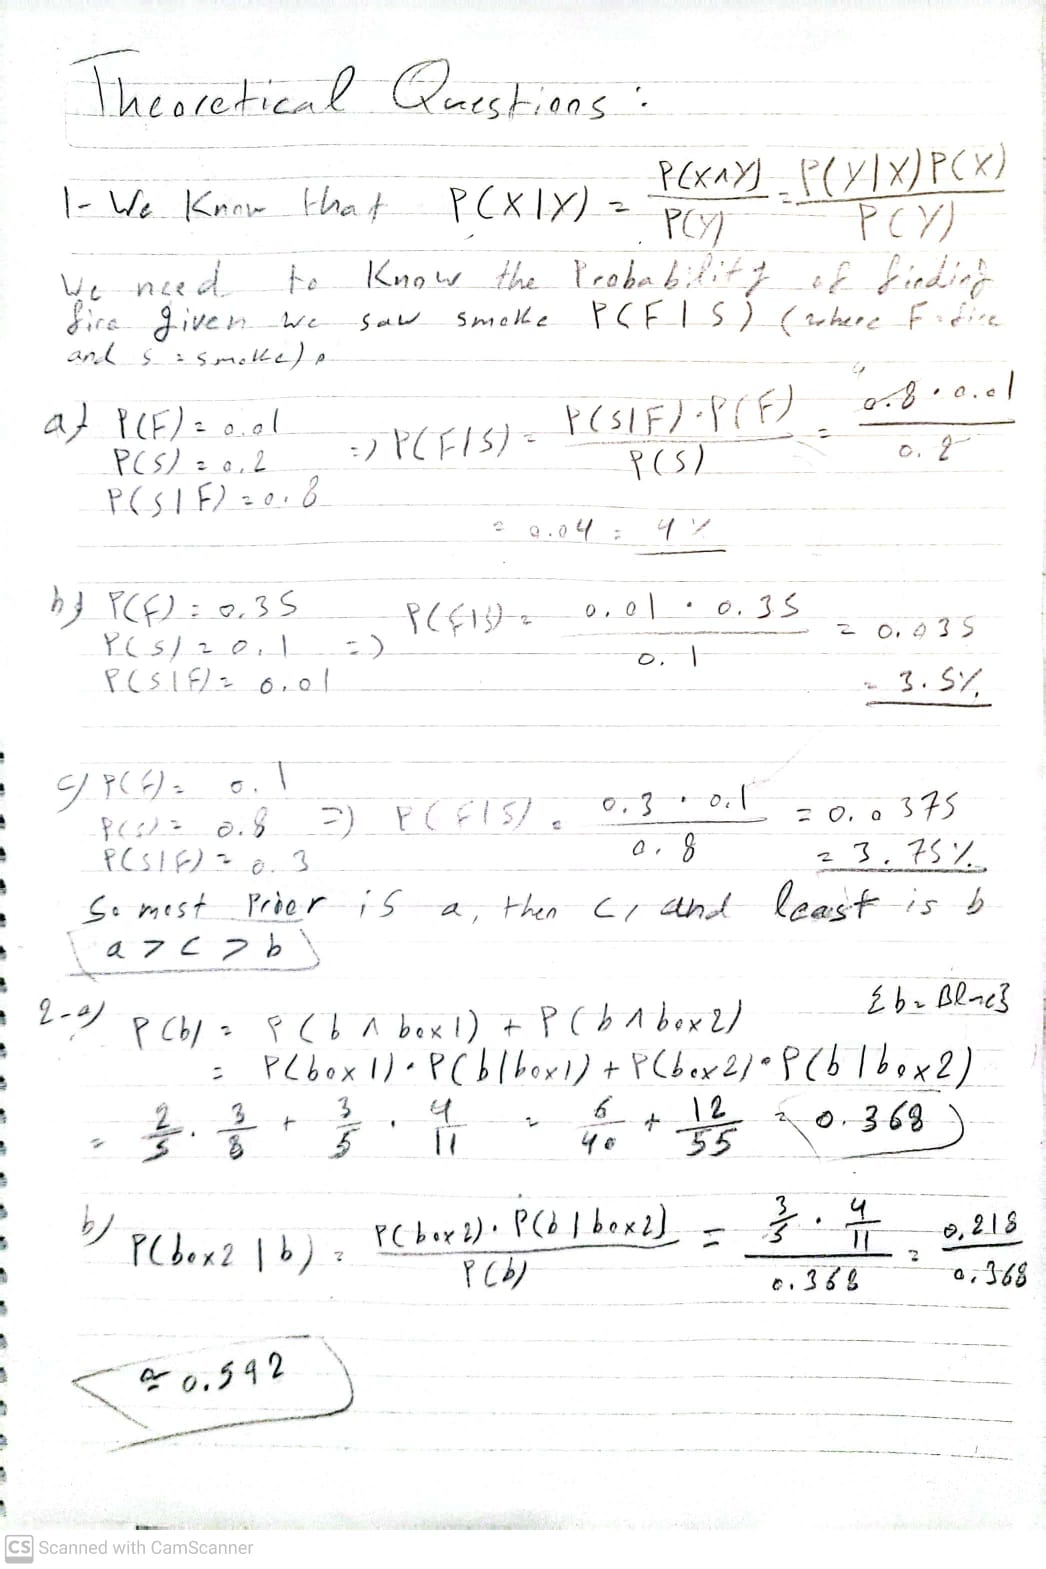

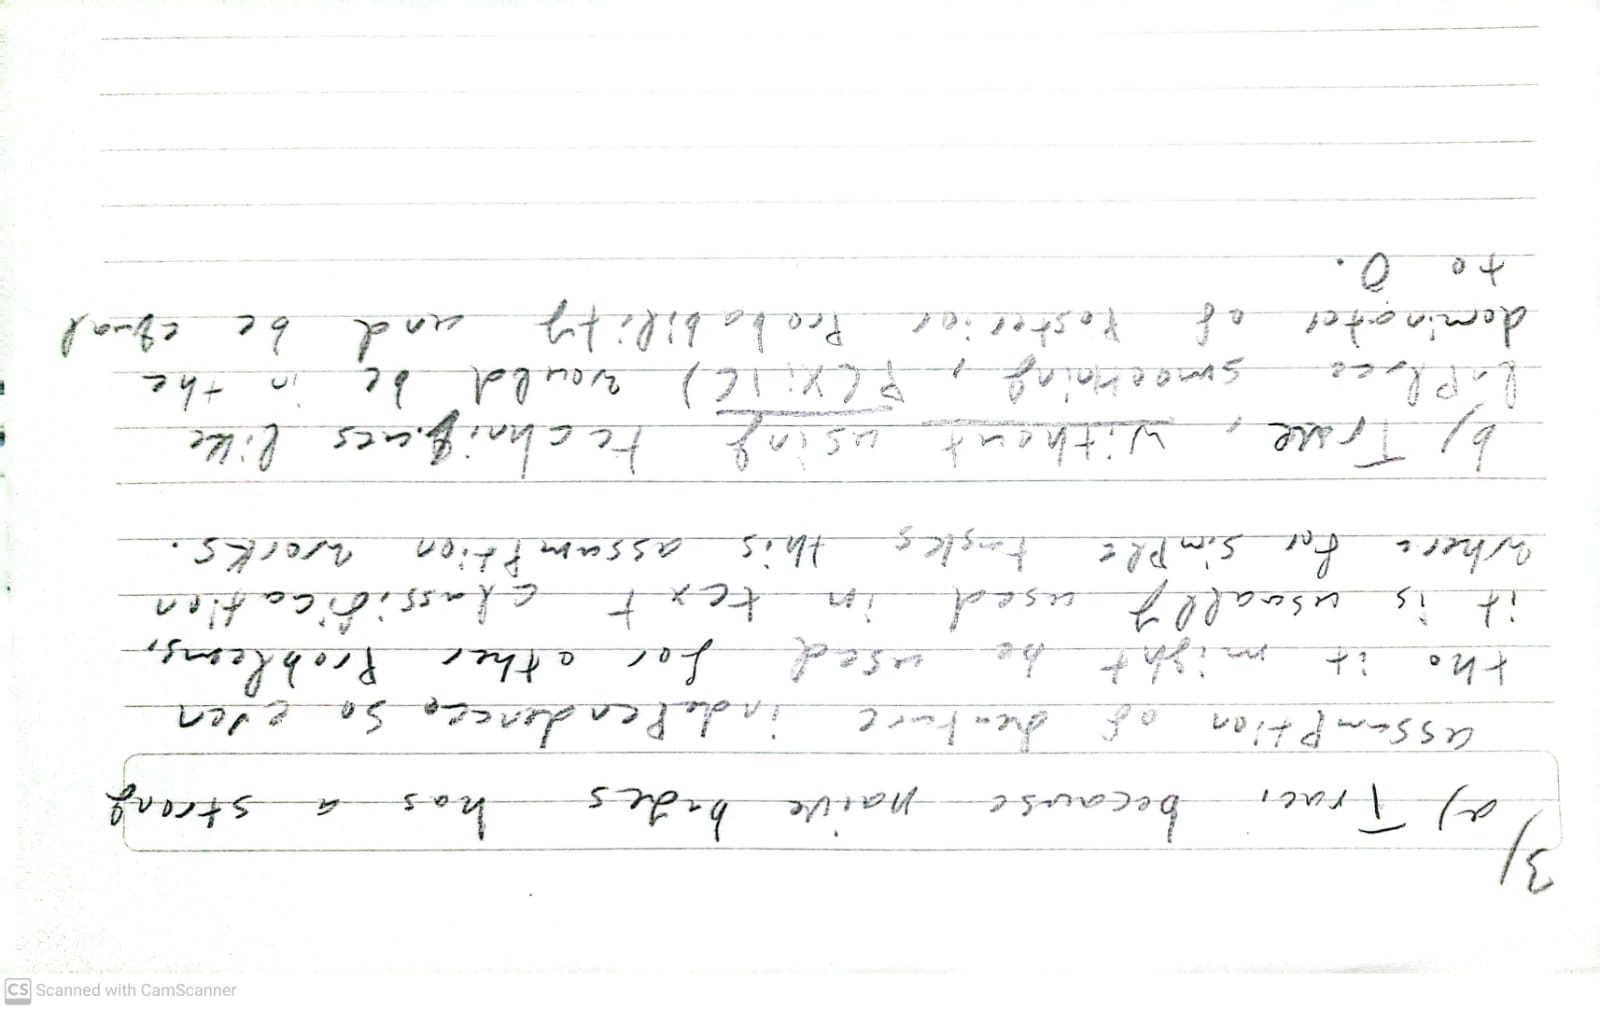

In [1]:
from IPython.display import Image
display(Image(filename='theory1.jpeg')) 
display(Image(filename='theory2.jpeg')) 

# Part 2: Move Review Classification

In [ ]:
#Installation commands are as follows:

!pip install ipython
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install nltk
!pip install gensim

#Might need:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

## N-Gram Naive Bayes Classifier

In [1]:
#Import necessary libraries

import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#A simply function to extract comments and their labels and return a dataframe
def extractComments(positiveFilePath, negativeFilePath, label):
    comments_ = []

    for path in [positiveFilePath, negativeFilePath]:
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
                
            with open(file_path, 'r') as file:
                content = file.read()
                comments_.append(content)

    rate = [1] * 12500 + [0] * 12500
    dfDict = {"Comment" : comments_, "Rating" : rate}
    df = pd.DataFrame(dfDict)
    df.to_csv(label, index=False)

    return df

In [31]:
# Commented segment is when running the program for the first time to create csv files out of the data that we have

# positiveFilePathTrain = "aclImdb/train/pos"
# negativeFilePathTrain = "aclImdb/train/neg"
# trainDf = extractComments(positiveFilePathTrain, negativeFilePathTrain, "trainReview.csv")

# positiveFilePathTest = "aclImdb/test/pos"
# negativeFilePathTest = "aclImdb/test/neg"
# testDf = extractComments(positiveFilePathTest, negativeFilePathTest, "testReview.csv")


# This part is for reading the dataset as a csv file the has been split to train and test files and shuffling them
trainDf = pd.read_csv("trainReview.csv")
testDf = pd.read_csv("testReview.csv")

trainDf = trainDf.sample(frac=1.0, random_state=7).reset_index(drop=True)
testDf = testDf.sample(frac=1.0, random_state=7).reset_index(drop=True)


# These are the stopwords that I noticed that affect the results the most and removing them helps
stopwords = ("the", "is", "a", "and", "to", "it", "at", "as", "in", "me", "this", "that", "i", "he",
                 "of", "br", "you", "have", "not", "be", "there", "are", "on", "my", "was", "has", "",
                 "i")

In [34]:
# This function takes in n as in Ngram to choose (unigram, bigram etc..), dataframe and chosen
# stopwords, and returns all possible nGrams with their count of occurance

def returnNGrams(n, df, stopwords):
    posNGram = {}
    negNGram = {}

    prevs = [""] * n

    # Iterating through negative reviews
    for review in df[df["Rating"] == 0]["Comment"]:

        # Tokenizing by lowering and splitting string, then specifying first n words as the first nGram
        tokens = review.lower().split()
        foundWords = 0

        for word in tokens[n:]:

            # Remove <>/ symbols and whitespaces
            word = re.sub(r'[<>/]', '', word).strip()
            if word in stopwords: 
                continue
            
            if foundWords != n:
                prevs[foundWords] = word
                foundWords += 1
                continue

            nGram = "_".join(prevs)

            # Add count of Ngram and process the next nGram
            negNGram[nGram] = negNGram.get(nGram, 0) + 1

            prevs.pop(0)
            prevs.append(word)

    # Iterating through positive reviews with the same approach
    for review in df[df["Rating"] == 1]["Comment"]:

        tokens = review.lower().split()
        foundWords = 0

        for word in tokens[n:]:
            word = re.sub(r'[<>/]', '', word).strip()
            if word in stopwords: 
                continue
            
            if foundWords != n:
                prevs[foundWords] = word
                foundWords += 1
                continue
            

            nGram = "_".join(prevs)

            posNGram[nGram] = posNGram.get(nGram, 0) + 1

            prevs.pop(0)
            prevs.append(word)

            
    return [posNGram, negNGram]
            

In [104]:
# This function is to plot the highest 10 NGrams in positive/negative dictonaries in 2 bar chart

def plotTop(dfPositive, dfNegative):
    plt.figure(figsize=(14, 6))

    top_10 = dict(sorted(dfPositive.items(), key=lambda item: item[1], reverse=True)[:10])

    NGrams = list(top_10.keys())
    frequencies = list(top_10.values())

    plt.subplot(1, 2, 1)
    plt.title("Positive")
    plt.bar(NGrams, frequencies)
    plt.xticks(rotation=45) 

    top_10 = dict(sorted(dfNegative.items(), key=lambda item: item[1], reverse=True)[:10])

    NGrams = list(top_10.keys())
    frequencies = list(top_10.values())

    plt.subplot(1, 2, 2)
    plt.title("Negative")
    plt.bar(NGrams, frequencies)
    plt.xticks(rotation=45) 
    
    plt.show()

In [38]:
# The main naive bayes classifier that predicts a class based on a string, given positive and negative NGrams counts with n

def predict(string, positive, negative, n):
    positiveScore = 0
    negativeScore = 0

    # Calculating the denominator of the naive bayes formula with Laplace smoothing
    positiveWordCount = sum(positive.values()) + len(positive.keys())
    negativeWordCount = sum(negative.values()) + len(negative.keys())

    # tokenizing and preparing first NGram with n words 
    tokens = string.lower().split()
    foundWords = 0
    prev = [""] * n

    for word in tokens[n:]:
        if word in stopwords:
            continue

        if foundWords != n:
                prev[foundWords] = word
                foundWords += 1
                continue
            

        nGram = "_".join(prev)

        # Look up for NGram frequency, if not found then numerator is 1 over wordCount, we take log and add it to respective score
        positiveScore += math.log((positive.get(nGram, 0) + 1) / positiveWordCount)
        negativeScore += math.log((negative.get(nGram, 0) + 1) / negativeWordCount)

        # Prepare next NGram
        prev.pop(0)
        prev.append(word)

    # Return class
    return positiveScore > negativeScore

In [6]:
# At the end we have a simple function to print the metrics and confusion matrix.

def print_metrics(y_pred, y_true):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.2f}")

    # Precision
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Precision: {precision:.2f}")

    # Recall
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Recall: {recall:.2f}")

    # F1
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"F1 Score: {f1:.2f}\n")

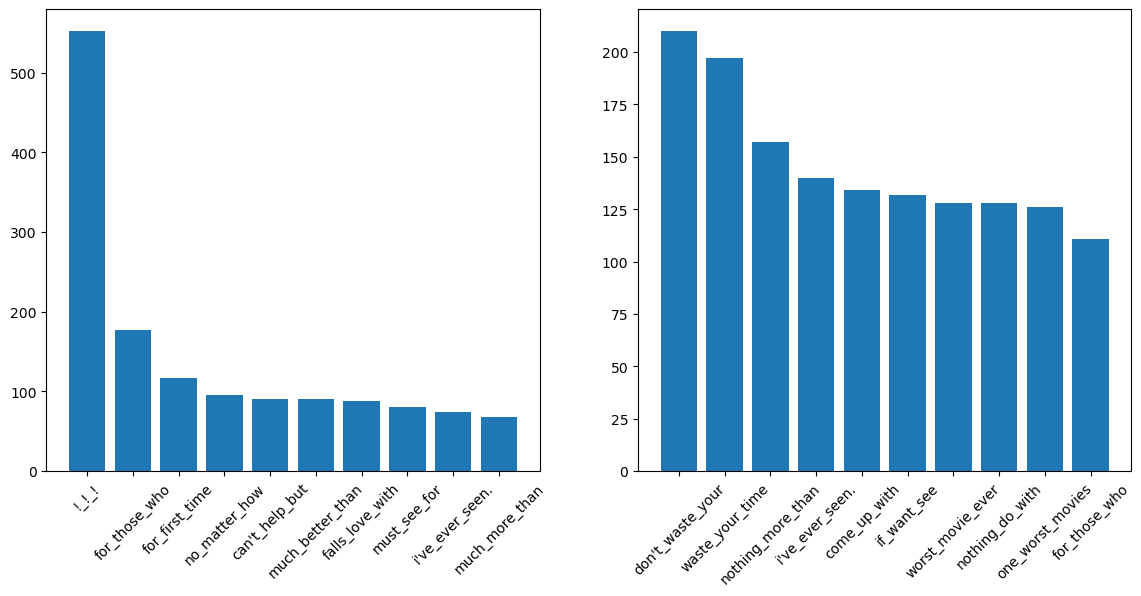

In [35]:
positiveBigram, negativeBigram = returnNGrams(3, trainDf, stopwords)

plotTop(positiveBigram, negativeBigram)

If we look at our distributions we can see some interesting information like using !!! in a review will highly tip the favor to the review being positive, or using other sentences like falls in love with, i have ever seen, waste you time, one of the worst movies are some sentences that highly affect the classification to be either positive or negative

In [39]:
# In this loop we try to find the best NGram for our purpose by iterating through different n values,
# creating corresponding NGram counters, and testing and picking the one with the best F1 Score

for n in range(1, 5):
    positiveNGram, negativeNGram = returnNGrams(n, trainDf, stopwords)

    preds = []

    for index, row in testDf.head(1000).iterrows():
        y = predict(row["Comment"], positiveNGram, negativeNGram, n)
        preds.append(y)

    f1Score = f1_score(testDf.head(1000)["Rating"], preds, average='weighted', zero_division=0)
    print("F1 Score for n = " + str(n) + " is: " + str(f1Score)) 

F1 Score for n = 1 is: 0.8188731690810357
F1 Score for n = 2 is: 0.8226714266469082
F1 Score for n = 3 is: 0.6260182757595695
F1 Score for n = 4 is: 0.40970218888376714


After we ran testing on 1-4 n values on 1k comments we can observe Based on these outputs that our model doesn't really like high n values. Which is porbably because our data size is low compared to trigrams or quadragrams. In theory yes we are getting higher context by raising the number of words. However, in our situation since we dont have much data our model is overfitting to some phrases that if non-existing in a review, the models won't be able to classify.

In [40]:
positiveNGram, negativeNGram = returnNGrams(2, trainDf, stopwords)

preds = []

for index, row in testDf.iterrows():
    y = predict(row["Comment"], positiveNGram, negativeNGram, 2)
    preds.append(y)

print_metrics(preds, testDf["Rating"])

Confusion Matrix:
[[11876   624]
 [ 4040  8460]]
Accuracy: 0.81
Precision: 0.84
Recall: 0.81
F1 Score: 0.81



Our scores have similar values with all being near 81%, which is not bad. Although the model seems to be a bit negative happy with more FNs

## Naive Bayes Classification With TF-IDF

In [19]:
posUnigram, posBigram = returnNGrams(1, trainDf, stopwords)
negUnigram, negBigram = returnNGrams(0, trainDf, stopwords)

In [41]:
# We first create a set with all unique words for our vector dimensions and create a wordToIndex dictionary
# for later use

words = []

for comment in trainDf["Comment"]:
    splitComment = comment.lower().split()
    for word in list(set(splitComment)):
        word = re.sub(r'[<>/]', '', word)
        words.append(word)

uniqueWords = set(words)

wordToIndex = {word:index for index,word in enumerate(uniqueWords)}

In [44]:
# After we create an IDF vector with all zeros, we calculate the IDF value for each word by first counting how many documents
# did each word appear and then calculating idfFinal which is log(documenSize/x) for all words

idf = np.zeros(len(uniqueWords))

for comment in trainDf['Comment']:
    splitComment = comment.lower().split()
    temp = np.array([0 for i in uniqueWords])
    for word in splitComment:
        word = re.sub(r'[<>/]', '', word)

        index = wordToIndex[word]

        temp[index] = 1
    idf += temp

idfFinal = np.log(25000 / idf)

In [45]:
# This code calculates TF for every word one document at a time, and accumelates its values
# into the corpus vector tfidf

tfidf = np.zeros(len(uniqueWords))

for comment in trainDf['Comment']:
    splitComment = comment.lower().split()
    temp = np.zeros(len(uniqueWords))
    for word in splitComment:
        word = re.sub(r'[<>/]', '', word)

        index = wordToIndex[word]

        # Calculate TF of the word in the document/review
        temp[index] += 1/len(splitComment)

    # add score of words regarding the document to tfidf
    tfidf += temp * idfFinal

In [46]:
# A simple function to get the weight of a word if it exists in tfidf vector, or 0 otherwise.

def getTfidfWeight(word):
    index = wordToIndex.get(word, -1)

    tfidfWeight = 0
    if index != -1:
        tfidfWeight = tfidf[index]

    return tfidfWeight

In [47]:
# The main naive bayes classifier that predicts a class based on a string, given positive and negative NGrams counts with n
# and includes tfidf weights into calculations

def predictTfidf(review, tfidf, positive, negative):
    posScore = 0
    negScore = 0
    
    vocabSize = len(tfidf)
    positiveWordCount = sum(positive.values()) + vocabSize
    negativeWordCount = sum(negative.values()) + vocabSize
    
    words = review.lower().split()
    
    for word in words:
        word = re.sub(r'[<>/]', '', word)
        tfidfWeight = getTfidfWeight(word)

        posFreq = positive.get(word, 0) + 1
        negFreq = negative.get(word, 0) + 1

        # Here we multiply our numerator with the weight and add a little value for smoothing
        posScore += math.log((posFreq / positiveWordCount) * tfidfWeight + 1e-10)
        negScore += math.log((negFreq / negativeWordCount) * tfidfWeight + 1e-10)

    return posScore > negScore

In [50]:
# We arent going to use stopwords since this algorithm should nullify them since they appear
# in most reviews and their idf will be so low

posUnigram, negUnigram = returnNGrams(1, trainDf, stopwords=[])

tfPreds = []

for index, row in testDf.iterrows():
    y = predictTfidf(row["Comment"], tfidf, posUnigram, negUnigram)
    tfPreds.append(y)

In [51]:
print_metrics(tfPreds, testDf["Rating"])

Confusion Matrix:
[[10917  1583]
 [ 2934  9566]]
Accuracy: 0.82
Precision: 0.82
Recall: 0.82
F1 Score: 0.82



We can see that even without specifying stopwords, we were able to acheive scores that are a bit better from normal naive bayes, which we couldn't acheive without specifying stop words in the last part. This shows a strong side of TFIDF, being able to automatically black out or show importance to words based on the field, regardless of the language.

## NLTK

In [93]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from nltk.probability import FreqDist

def text_prep(x):
     tokens = word_tokenize(x)
     # Lowercase
     tokens = [token.lower() for token in tokens]
     # Remove punctuation
     tokens = [token for token in tokens if token not in string.punctuation]
     # Remove stopwords
     stopWords = set(stopwords.words("english"))
     customStopwords = {"movie", "film", "br", "", " "}
     stopWords.update(customStopwords)
     tokens = [token for token in tokens if token not in stopWords]
     # Stemming (optional)
     stemmer = PorterStemmer()
     tokens = [stemmer.stem(token) for token in tokens]
     return tokens

In [101]:
# This function takes in n as in Ngram to choose (unigram, bigram etc..), dataframe and chosen
# stopwords, and returns all possible nGrams with their count of occurance

def returnNGramsPreprocessed(n, df):
    posNGram = {}
    negNGram = {}

    prevs = [""] * n

    # Iterating through negative reviews
    for review in df[df["Rating"] == 0]["Comment"]:

        # Tokenizing by using the NLTK text processing function that we made earlier
        tokens = text_prep(review)
        foundWords = 0

        for word in tokens[n:]:
            if foundWords != n:
                prevs[foundWords] = word
                foundWords += 1
                continue

            nGram = "_".join(prevs)

            # Add count of Ngram and process the next nGram
            negNGram[nGram] = negNGram.get(nGram, 0) + 1

            prevs.pop(0)
            prevs.append(word)

    # Iterating through positive reviews with the same approach
    for review in df[df["Rating"] == 1]["Comment"]:

        tokens = text_prep(review)
        foundWords = 0

        for word in tokens[n:]:
            if foundWords != n:
                prevs[foundWords] = word
                foundWords += 1
                continue
            

            nGram = "_".join(prevs)

            posNGram[nGram] = posNGram.get(nGram, 0) + 1

            prevs.pop(0)
            prevs.append(word)

            
    return [posNGram, negNGram]           

posNltkUnigram, negNltkUnigram = returnNGramsPreprocessed(1, trainDf)
posNltkBigram, negNltkBigram = returnNGramsPreprocessed(2, trainDf)

In [109]:
# Just like previous prediction functions, except it preprocesses text using NLTK before prediction

def predictNLTK(string, positive, negative, n):
    positiveScore = 0
    negativeScore = 0

    positiveWordCount = sum(positive.values()) + len(positive.keys())
    negativeWordCount = sum(negative.values()) + len(negative.keys())

    reviewProcessed = text_prep(string)
    foundWords = 0
    prev = [""] * n

    for word in reviewProcessed:
        if foundWords != n:
            prev[foundWords] = word
            foundWords += 1
            continue


        nGram = "_".join(prev)
        positiveScore += math.log((positive.get(nGram, 0) + 1) / positiveWordCount)
        negativeScore += math.log((negative.get(nGram, 0) + 1) / negativeWordCount)


        prev.pop(0)
        prev.append(word)

    return positiveScore > negativeScore

In [112]:
# Again, we are testing iterating through all comments

nltkUniPreds = []
nltkBiPreds = []

for index, row in testDf.iterrows():
    y0 = predictNLTK(row["Comment"], posNltkUnigram, negNltkUnigram, 1)
    y1 = predictNLTK(row["Comment"], posNltkBigram, negNltkBigram, 2)
    nltkUniPreds.append(y0)
    nltkBiPreds.append(y1)

In [113]:
print_metrics(nltkUniPreds, testDf["Rating"])
print_metrics(nltkBiPreds, testDf["Rating"])

Confusion Matrix:
[[10961  1539]
 [ 3082  9418]]
Accuracy: 0.82
Precision: 0.82
Recall: 0.82
F1 Score: 0.81

Confusion Matrix:
[[11828   672]
 [ 4504  7996]]
Accuracy: 0.79
Precision: 0.82
Recall: 0.79
F1 Score: 0.79



This has been the worst so far being slightly off previous methods. This means that we were able to deduce and filter words better when we didnt process words through lemmatization and removing more stop words.

## Word Embedding + Logistic Regression

In [52]:
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

# Word embeddings weights path. Needs to be downloaded
word2vec_model_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

In [53]:
# This function takes average of all words' embeddings in a given text or returns zero if none was embedded

def get_average_word_embedding(text, word_embedding_model):
    words = text.split()
    embeddings = [word_embedding_model[word] for word in words if word in word_embedding_model]
    
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word_embedding_model.vector_size)

In [54]:
# We get embeddings of each comment as a whole with average function for train and test

trainEmbeddings = []

for comment in trainDf["Comment"]:
    embedding = get_average_word_embedding(comment, word2vec_model)
    trainEmbeddings.append(embedding)

testEmbeddings = []

for comment in testDf["Comment"]:
    embedding = get_average_word_embedding(comment, word2vec_model)
    testEmbeddings.append(embedding)

In [55]:
# Turn them into dataframes with shapes 25000, 300

trainEmbeddingDf = pd.DataFrame(trainEmbeddings)
testEmbeddingDf = pd.DataFrame(testEmbeddings)

In [56]:
# Train the model and predict

model = LogisticRegression(max_iter=2000)

model.fit(trainEmbeddingDf, trainDf["Rating"])

ypred = model.predict(testEmbeddingDf)

print_metrics(ypred, testDf["Rating"])

Confusion Matrix:
[[10449  2051]
 [ 2248 10252]]
Accuracy: 0.83
Precision: 0.83
Recall: 0.83
F1 Score: 0.83



Word Embedding with logistic regression gave results the best results so far with 83% accuracy, being slightly better than TFIDF and normal naive bayes. Having more iterations was tried and it seems like it converges at this point. And having a word embedding logistic regression model capped at 83% might mean that we are becoming close to the point where normal processing of the data and shallow models advancements will give low benefits compared to more complicated RNNs or neural networks